<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/VGG(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                                ↑↑↑↑↑↑
                                        위의 Open in Colab 을 누르면 훨씬 가독성 있게 볼 수 있습니다.

# 1. 패키지 로드

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 3.6 MB/s 
     |████████████████████████████████| 37.1 MB 82 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. 논문 분석

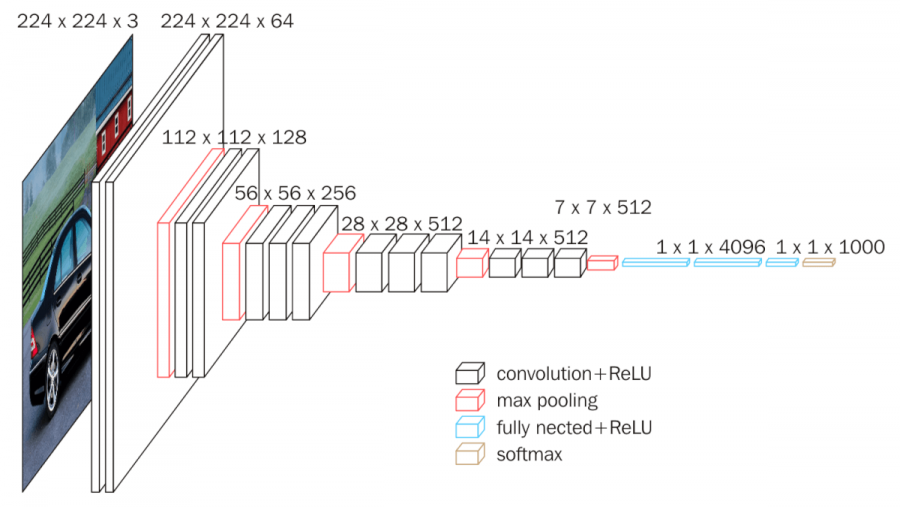

* VGGNet 부터 CNN모델들이 깊어지기 시작 이는, 모든 필터 사이즈를 3x3으로 설정하여 가중치를 크게 줄였기 때문.
* Receptive Field : 3x3 필터가 2개 연속으로 나오면 사실상 5x5 필터와 같은 범위에서 feature를 뽑아 내는 것이고, 3x3 필터가 3개 연속으로 나오면 사실상 7x7필터와 같은 범위를 다룰 수 있다(아래 그림). 이 방법으로 오히려 가중치수를 크게 줄일 수 있었으며, VGGnet 등장부터 모델들이 깊어지기 시작했다.
* conv를 2번 혹은 3번을 적용 하고, pooling하여 feature map을 만들어낸다. 이 때, 2x2로 feature map 크기를 2배로 줄이지만, 동시에 채널을 2배로 늘리는 방식을 채택.
* 구조가 feature map 기준으로 블럭 단위로 이루어졌다고 보고 block 단위 구현해보기
* 이미지에 관해서는 multi-scale을 하였음. [Smin, Smax]를 정해서, 여기서는 256~ 512 단위로 랜덤으로 바꾸어주고, 다음으로 224x224로 랜덤 crop을 하였음. 이런 방식을 sacle jittering 이라 불렀음. 다만, 스피드를 이유로 S = 384사이즈의 single-scale로 pre-train을 한 후 fine-tuning을 하였음. 

* 그 외 디테일한 내용 
    * SGD(mini batch 사용)
    * 배치 사이즈는 256, 모멘텀 0.9, dropout 0.5
    * weight decay(L2 penalty 이용) 5*10^-4 = 0.0005
    * learning rate 초기 치는 0.01 , 정확도 향상이 멈추면 1/10
    * 논문에서는 3번 멈춘 74 epoch
    * bias는 초기값 0
    * 가중치 초기화 부분에서 사전 훈련을 사용했지만 이 후 논문에서 worth noting 한 것을 확인 따라서 다루지 않겠음.
    * RGB colour shift >> PCA 이용
    * flatten 전에 gloabal average pooling 사용

 

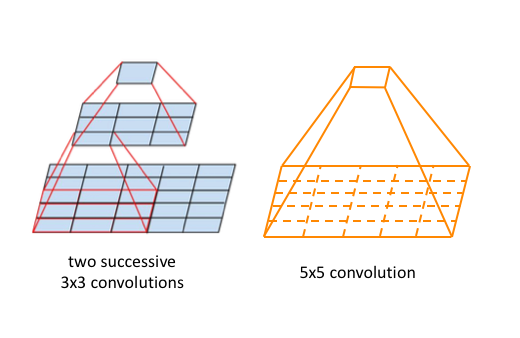

# 3. 구현

## 블럭 구현

In [ ]:
class block(nn.Module):

    def __init__(self, in_channels ,out_channels,repeats = 2):
        super(block, self).__init__()
        layers = []

        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(repeats-1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'))   
            layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        self.conv_layer = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv_layer(x)


In [ ]:
model = block(3,64).to(device)
summary(model, (3, 224,224))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 104.12
Params size (MB): 0.15
Estimated Total Size (MB): 104.85
----------------------------------------------------------------
block(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU(inplace=Tr

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## VGG16 구현

summary로 확인

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes = 1000):
        super(VGG16, self).__init__()
        self.block1 = block(3,64)
        self.block2 = block(64,128)
        self.block3 = block(128,256, repeats= 3)
        self.block4 = block(256,512, repeats= 3)
        self.block5 = block(512,512, repeats= 3)
        self.gap =  nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

        
        self.classifier = nn.Sequential(
            
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(4096, 120),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(120, num_classes),
        )

        self._initialize_weights()


    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.gap(x)
        x = self.flatten(x) 
        # x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

    # 가중치 초기화 함수는 torch공식 문서 그대로
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
    #             m.weight.data.normal_(0, math.sqrt(2. / n))
    #             if m.bias is not None:
    #                 m.bias.data.zero_()
    #         elif isinstance(m, nn.BatchNorm2d):
    #             m.weight.data.fill_(1)
    #             m.bias.data.zero_()
    #         elif isinstance(m, nn.Linear):
    #             m.weight.data.normal_(0, 0.01)
    #             m.bias.data.zero_()


    # 위랑 아래랑 정확히 동일한거라 생각드는데,
    # 직접 he normal 구현하는거랑 무슨 차이가 있는지 모르겠음.
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [ ]:
# 모델 확인
model = VGG16(10).to(device)
summary(model, (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
             block-6           [-1, 64, 48, 48]               0
            Conv2d-7          [-1, 128, 48, 48]          73,856
              ReLU-8          [-1, 128, 48, 48]               0
            Conv2d-9          [-1, 128, 48, 48]         147,584
             ReLU-10          [-1, 128, 48, 48]               0
        MaxPool2d-11          [-1, 128, 24, 24]               0
            block-12          [-1, 128, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         295,168
             ReLU-14          [-1, 256,

# 4. 데이터 전처리

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

(3, 96, 96)
torch.Size([3, 96, 96])


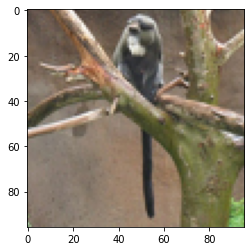

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

#????? totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


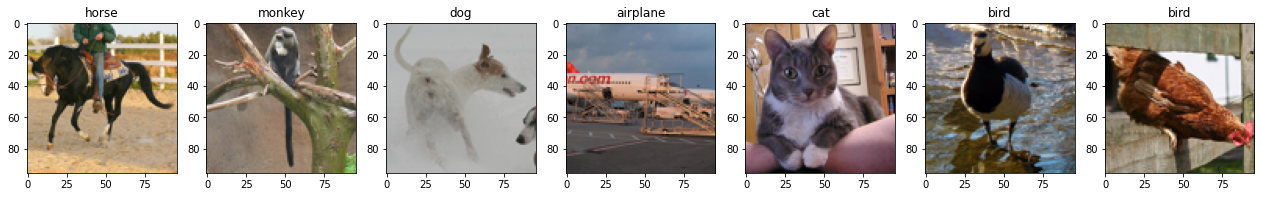

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.


            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    # A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    # A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 64
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




# 5. 학습 및 평가

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        output = model(images)
        sum_loss = criterion(output, target)
        loss = sum_loss/len(target)
        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.



        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch ):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []
    avg_train_accuracy = []
    avg_val_accuracy = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        avg_train_accuracy.append(train_accuracy)
        avg_val_accuracy.append(val_accuracy)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses,  avg_train_accuracy , avg_val_accuracy


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = VGG16(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')

# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:
model, train_loss, val_loss ,train_accuracy ,val_accuracy= fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

Epoch: 1. Train.: 100%|██████████| 125/125 [00:21<00:00,  5.73it/s]


[1] Train Loss: 2.2672, Accuracy: 11.49%


Epoch: 1. Validate.: 100%|██████████| 79/79 [00:04<00:00, 15.96it/s]


[1] Validation Loss: 2.2323, Accuracy: 16.98%
Validation loss decreased (inf --> 2.232252).



Epoch: 2. Train.: 100%|██████████| 125/125 [00:21<00:00,  5.71it/s]


[2] Train Loss: 2.0418, Accuracy: 16.48%


Epoch: 2. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.74it/s]


[2] Validation Loss: 1.8944, Accuracy: 18.80%
Validation loss decreased (2.232252 --> 1.894363).



Epoch: 3. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.65it/s]


[3] Train Loss: 1.9365, Accuracy: 18.48%


Epoch: 3. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.55it/s]


[3] Validation Loss: 1.9652, Accuracy: 18.28%
EarlyStopping counter: 1 out of 15



Epoch: 4. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.60it/s]


[4] Train Loss: 1.9064, Accuracy: 18.41%


Epoch: 4. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.51it/s]


[4] Validation Loss: 1.8348, Accuracy: 20.00%
Validation loss decreased (1.894363 --> 1.834809).



Epoch: 5. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.55it/s]


[5] Train Loss: 1.8936, Accuracy: 19.79%


Epoch: 5. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.25it/s]


[5] Validation Loss: 1.8074, Accuracy: 20.02%
Validation loss decreased (1.834809 --> 1.807416).



Epoch: 6. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.50it/s]


[6] Train Loss: 1.8910, Accuracy: 19.26%


Epoch: 6. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.38it/s]


[6] Validation Loss: 1.8024, Accuracy: 20.04%
Validation loss decreased (1.807416 --> 1.802368).



Epoch: 7. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.48it/s]


[7] Train Loss: 1.8726, Accuracy: 19.12%


Epoch: 7. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.42it/s]


[7] Validation Loss: 1.8254, Accuracy: 20.14%
EarlyStopping counter: 1 out of 15



Epoch: 8. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.47it/s]


[8] Train Loss: 1.8643, Accuracy: 20.20%


Epoch: 8. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.11it/s]


[8] Validation Loss: 1.8345, Accuracy: 23.58%
EarlyStopping counter: 2 out of 15



Epoch: 9. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.44it/s]


[9] Train Loss: 1.8564, Accuracy: 21.05%


Epoch: 9. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.18it/s]


[9] Validation Loss: 1.7665, Accuracy: 23.22%
Validation loss decreased (1.802368 --> 1.766456).



Epoch: 10. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.47it/s]


[10] Train Loss: 1.8308, Accuracy: 22.59%


Epoch: 10. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.19it/s]


[10] Validation Loss: 1.7543, Accuracy: 26.40%
Validation loss decreased (1.766456 --> 1.754294).



Epoch: 11. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.45it/s]


[11] Train Loss: 1.8087, Accuracy: 24.19%


Epoch: 11. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.19it/s]


[11] Validation Loss: 1.7113, Accuracy: 26.98%
Validation loss decreased (1.754294 --> 1.711274).



Epoch: 12. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.48it/s]


[12] Train Loss: 1.7956, Accuracy: 25.41%


Epoch: 12. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.19it/s]


[12] Validation Loss: 1.7814, Accuracy: 28.98%
EarlyStopping counter: 1 out of 15



Epoch: 13. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.46it/s]


[13] Train Loss: 1.7683, Accuracy: 26.69%


Epoch: 13. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.24it/s]


[13] Validation Loss: 1.7064, Accuracy: 30.56%
Validation loss decreased (1.711274 --> 1.706381).



Epoch: 14. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.46it/s]


[14] Train Loss: 1.7508, Accuracy: 27.75%


Epoch: 14. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.12it/s]


[14] Validation Loss: 1.6466, Accuracy: 32.08%
Validation loss decreased (1.706381 --> 1.646551).



Epoch: 15. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.47it/s]


[15] Train Loss: 1.7374, Accuracy: 28.32%


Epoch: 15. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.30it/s]


[15] Validation Loss: 1.6281, Accuracy: 33.28%
Validation loss decreased (1.646551 --> 1.628050).



Epoch: 16. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.45it/s]


[16] Train Loss: 1.7186, Accuracy: 29.25%


Epoch: 16. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.00it/s]


[16] Validation Loss: 1.6563, Accuracy: 32.70%
EarlyStopping counter: 1 out of 15



Epoch: 17. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.45it/s]


[17] Train Loss: 1.7047, Accuracy: 29.48%


Epoch: 17. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.10it/s]


[17] Validation Loss: 1.6042, Accuracy: 32.58%
Validation loss decreased (1.628050 --> 1.604238).



Epoch: 18. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.44it/s]


[18] Train Loss: 1.7018, Accuracy: 30.05%


Epoch: 18. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.11it/s]


[18] Validation Loss: 1.6188, Accuracy: 32.34%
EarlyStopping counter: 1 out of 15



Epoch: 19. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.44it/s]


[19] Train Loss: 1.6891, Accuracy: 31.35%


Epoch: 19. Validate.: 100%|██████████| 79/79 [00:05<00:00, 15.13it/s]


[19] Validation Loss: 1.5779, Accuracy: 33.72%
Validation loss decreased (1.604238 --> 1.577930).



Epoch: 20. Train.: 100%|██████████| 125/125 [00:22<00:00,  5.45it/s]


[20] Train Loss: 1.6725, Accuracy: 30.14%


Epoch: 20. Validate.:  76%|███████▌  | 60/79 [00:04<00:01, 14.55it/s]


KeyboardInterrupt: ignored

## 평가

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Validation Accuracy')

# validation Accuracy의 최대값 지점을 찾기
maxposs = val_accuracy.index(max(val_accuracy))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_accuracy)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)